In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-plot
import scikitplot as skplt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import f1_score,fbeta_score,matthews_corrcoef, log_loss, confusion_matrix,classification_report,make_scorer,balanced_accuracy_score, plot_confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc,recall_score,roc_auc_score, average_precision_score, precision_score,plot_precision_recall_curve,precision_recall_curve,ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, learning_curve
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (OneHotEncoder, PowerTransformer, StandardScaler)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving predictive_maintenance.csv to predictive_maintenance.csv


In [ ]:
df=pd.read_csv('predictive_maintenance.csv')

In [ ]:
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [ ]:
df.drop(['Product ID',"UDI","Target","Type"], axis=1, inplace=True)

In [ ]:
df 

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,H,299.0,308.7,1408,48.5,25,0,No Failure


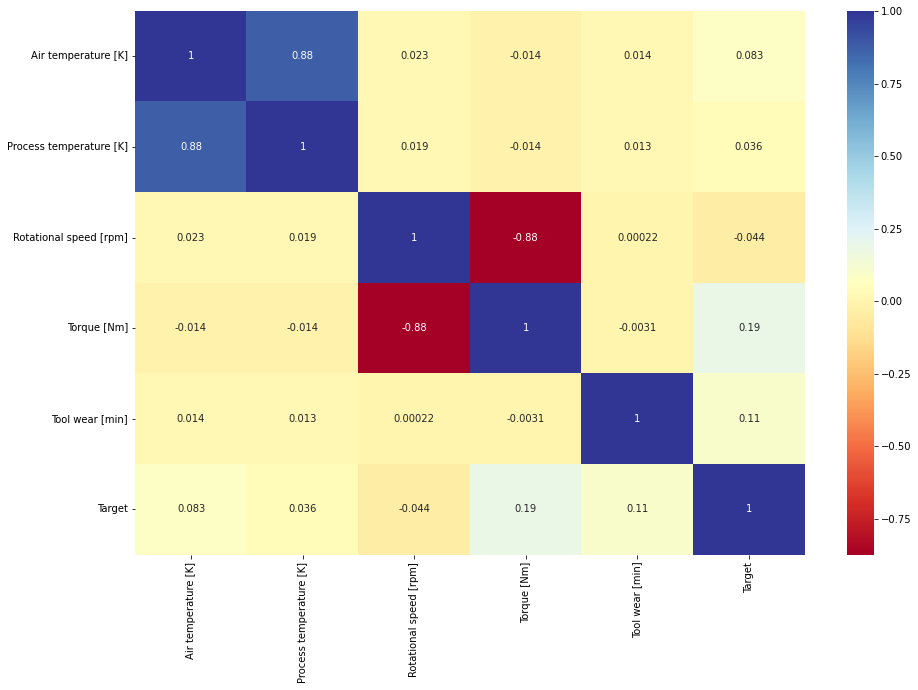

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot = True,cmap = "RdYlBu")
plt.draw()

In [ ]:
df.isnull().values.any()

False

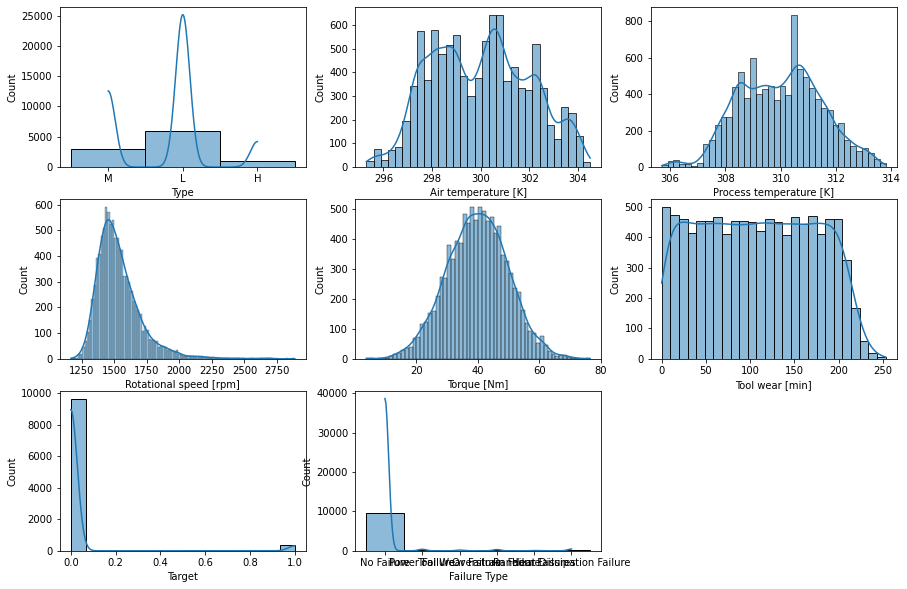

In [ ]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(df[col],kde=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa03b6be7d0>,
      dtype=object)

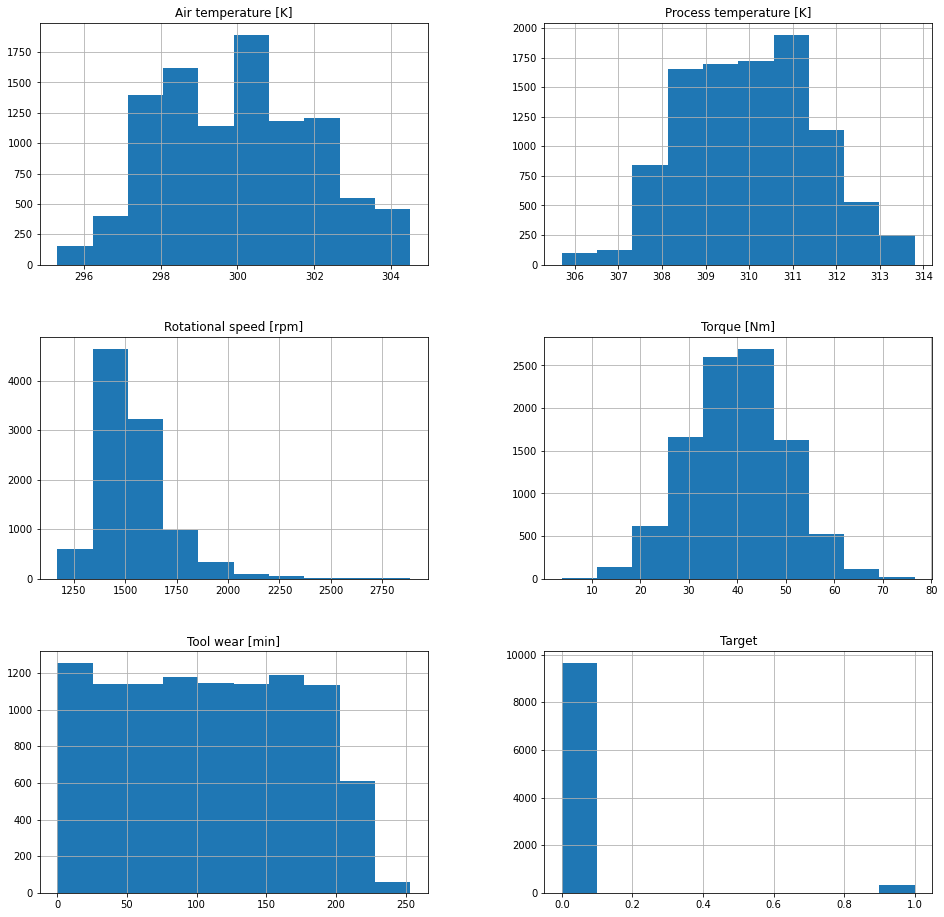

In [ ]:
df.hist(figsize=(16, 16))

In [ ]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


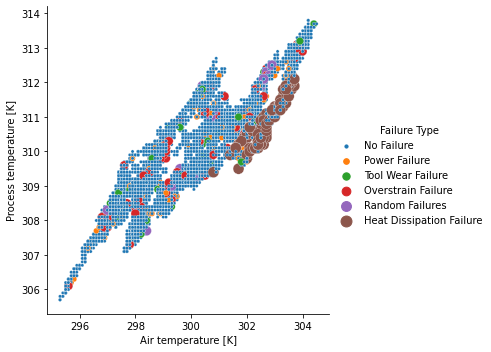

In [ ]:
_ = sns.relplot(x="Air temperature [K]", y="Process temperature [K]", hue="Failure Type",size="Failure Type", sizes=(120, 10),data=df)

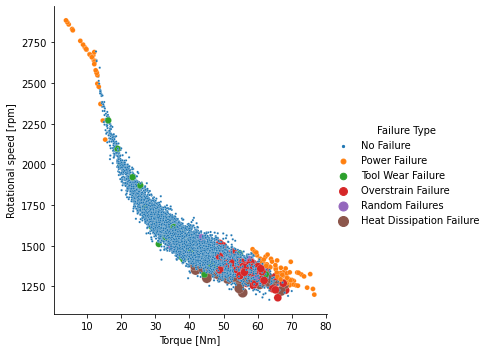

In [ ]:
_ = sns.relplot(x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",size="Failure Type", sizes=(100, 5),data=df)

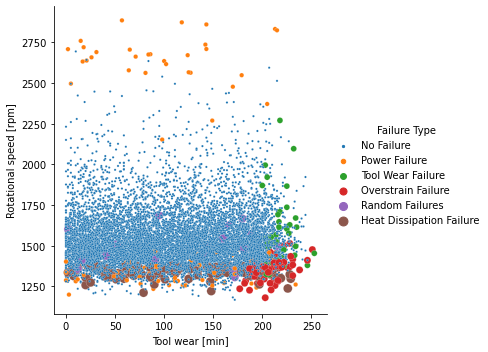

In [ ]:
_ = sns.relplot(x="Tool wear [min]", 
                y="Rotational speed [rpm]", 
                hue="Failure Type",
                size="Failure Type", 
                sizes=(80, 5), 
                data=df)

In [ ]:
df["Failure Type"].replace({"No Failure": 0,"Heat Dissipation Failure": 1,"Power Failure": 2,"Overstrain Failure": 3,"Tool Wear Failure": 4,"Random Failures": 5},inplace=True)

In [ ]:
df["Type"].replace({"H":0,"L":1,"M":2}, inplace=True)

In [ ]:
col_name=df.columns.to_list()

In [ ]:
predictive_columns = col_name[0:6]
X = df[predictive_columns]
y = df["Failure Type"]

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5, random_state=None)
for train_index,test_index in skf.split(X,y):
    x1_train,x1_test=X.iloc[train_index],X.iloc[test_index]
    y1_train,y1_test=y.iloc[train_index],y.iloc[test_index]
    train_0, train_1 = len(y1_train[y1_train==0]), len(y1_train[y1_train==1])
    test_0, test_1 = len(y1_test[y1_test==0]), len(y1_test[y1_test==1])
    print('train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

train: 0=7721, 1=90, Test: 0=1931, 1=22
train: 0=7721, 1=90, Test: 0=1931, 1=22
train: 0=7722, 1=90, Test: 0=1930, 1=22
train: 0=7722, 1=89, Test: 0=1930, 1=23
train: 0=7722, 1=89, Test: 0=1930, 1=23


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=40, test_size=0.33, stratify=y)

In [ ]:
from imblearn.combine import SMOTETomek
smote = SMOTETomek(random_state=42)
X1_res, y1_res = smote.fit_resample(X_train,y_train)

In [ ]:
X1_res.shape

(38748, 6)

In [ ]:
X1_res

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,1,297.500000,308.700000,1371,46.500000,121
1,2,297.400000,308.600000,1452,41.200000,197
2,2,296.400000,307.300000,2077,19.100000,80
3,1,300.400000,309.300000,1413,50.300000,101
4,1,297.400000,308.100000,1348,57.400000,66
...,...,...,...,...,...,...
38743,1,302.567982,312.035964,1437,42.908492,201
38744,1,302.766184,312.183092,1507,36.246384,79
38745,1,299.733107,309.612309,1567,35.541596,183
38746,1,302.463023,311.872267,1308,59.649157,168


In [ ]:
y1_res.shape

(38748,)

In [ ]:
df_x = pd.DataFrame(X1_res)

In [ ]:
df_x["Type"].replace({0:"H",1:"L",2:"M"}, inplace=True)

In [ ]:
df_y = pd.DataFrame(y1_res)

In [ ]:
df_y["Failure Type"].replace({0:"No Failure",1:"Heat Dissipation Failure",2:"Power Failure",3:"Overstrain Failure",4:"Tool Wear Failure",5:"Random Failures"},inplace=True)

In [ ]:
df1 = pd.concat([df_x,df_y], axis=1)

In [ ]:
df1['Failure Type'].value_counts()

Overstrain Failure          6467
Heat Dissipation Failure    6464
Power Failure               6462
Tool Wear Failure           6461
Random Failures             6454
No Failure                  6440
Name: Failure Type, dtype: int64

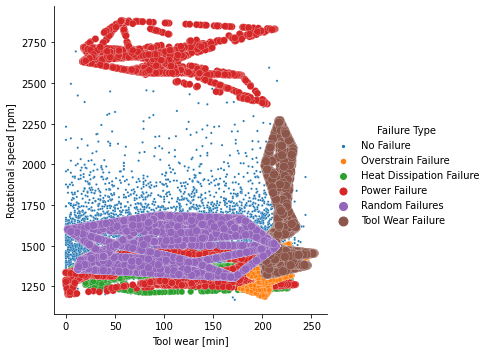

In [ ]:
_ = sns.relplot(x="Tool wear [min]", 
                y="Rotational speed [rpm]", 
                hue="Failure Type",
                size="Failure Type", 
                sizes=(80, 5), 
                data=df1)

In [ ]:
X_test.shape

(3300, 6)

In [ ]:
y_test.shape

(3300,)

In [ ]:
# Build categorical preprocessor
categorical_cols = X.select_dtypes(include="object").columns.to_list()
categorical_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))

# Build numeric processor
to_log = ["Rotational speed [rpm]",	"Tool wear [min]"]
to_scale = ["Air temperature [K]","Process temperature [K]", "Torque [Nm]"]
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())

# Full processor
full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, categorical_cols),
        ("power_transform", numeric_pipe_1, to_log),
        ("standardization", numeric_pipe_2, to_scale)])

In [ ]:
rfc = OutputCodeClassifier(RandomForestClassifier(), code_size=6, random_state=40)

In [ ]:
# Final pipeline combined with RandomForest
pipeline = Pipeline(
    steps=[("preprocess", full),("base",rfc)])

In [ ]:
model_rfc = pipeline.fit(X1_res, y1_res)
y_pred_rfc = model_rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3185
           1       0.40      0.62      0.49        37
           2       0.50      0.61      0.55        31
           3       0.67      0.77      0.71        26
           4       0.05      0.20      0.08        15
           5       0.00      0.00      0.00         6

    accuracy                           0.94      3300
   macro avg       0.43      0.53      0.47      3300
weighted avg       0.97      0.94      0.95      3300



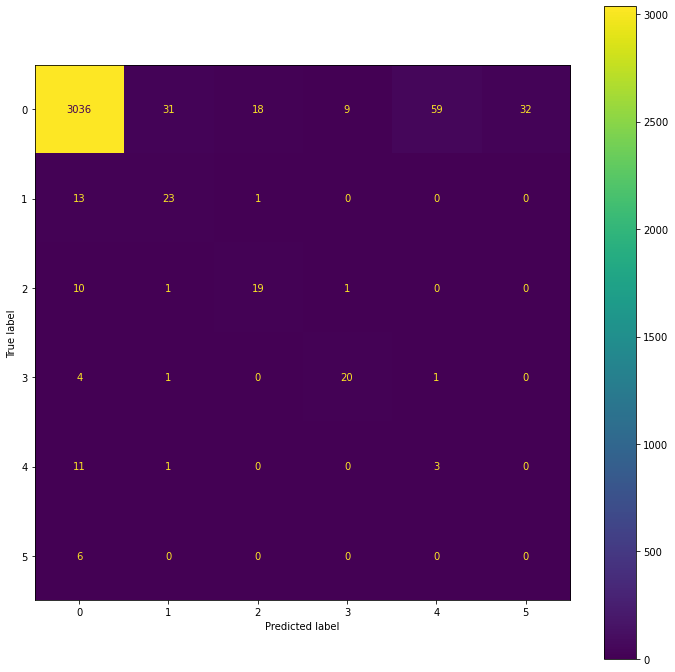

In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
print(classification_report(y_test, y_pred_rfc))
# Create the matrix
cm = confusion_matrix(y_test, y_pred_rfc)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();

In [ ]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3185
           1       0.40      0.62      0.49        37
           2       0.50      0.61      0.55        31
           3       0.67      0.77      0.71        26
           4       0.05      0.20      0.08        15
           5       0.00      0.00      0.00         6

    accuracy                           0.94      3300
   macro avg       0.43      0.53      0.47      3300
weighted avg       0.97      0.94      0.95      3300



In [ ]:
print("Accuracy Score: %.4f" %(accuracy_score(y_test,y_pred_rfc)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test,y_pred_rfc)))

Accuracy Score: 0.9397
Matthews correlation coefficient: 0.4113


In [ ]:
lgbm = OutputCodeClassifier(LGBMClassifier(), code_size=6, random_state=42)

In [ ]:
# Final pipeline combined with RandomForest
pipeline_lgbm = Pipeline(
    steps=[
        ("preprocess", full),
        ("base",lgbm,),])

In [ ]:
model_lgbm = pipeline_lgbm.fit(X1_res, y1_res)
y_pred_lgbm = model_lgbm.predict(X_test)

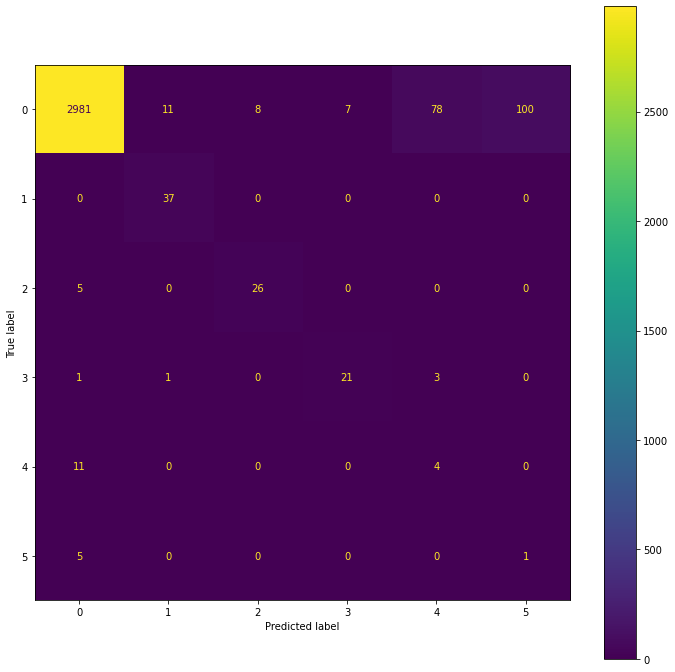

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3185
           1       0.76      1.00      0.86        37
           2       0.76      0.84      0.80        31
           3       0.75      0.81      0.78        26
           4       0.05      0.27      0.08        15
           5       0.01      0.17      0.02         6

    accuracy                           0.93      3300
   macro avg       0.55      0.67      0.58      3300
weighted avg       0.98      0.93      0.95      3300



In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
# Create the matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, y_pred_lgbm))

In [ ]:
print("Accuracy Score: %.4f" %(accuracy_score(y_test,y_pred_lgbm)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test,y_pred_lgbm)))

Accuracy Score: 0.9303
Matthews correlation coefficient: 0.4786


In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = OutputCodeClassifier(XGBClassifier(), code_size=6, random_state=42)

In [ ]:
# Final pipeline combined with RandomForest
pipeline_xgb = Pipeline(
    steps=[("preprocess", full),("base",xgb)])

In [ ]:
model_xgb = pipeline_xgb.fit(X1_res, y1_res)
y_pred_xgb = model_xgb.predict(X_test)

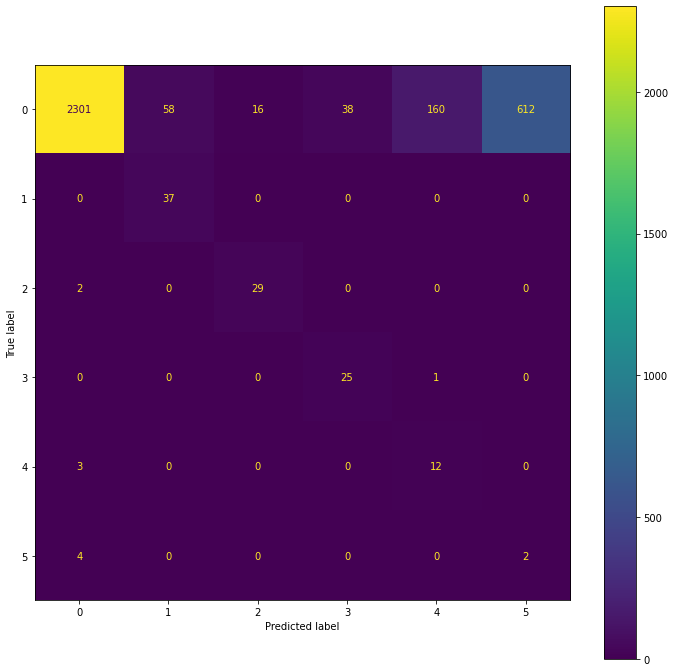

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      3185
           1       0.39      1.00      0.56        37
           2       0.64      0.94      0.76        31
           3       0.40      0.96      0.56        26
           4       0.07      0.80      0.13        15
           5       0.00      0.33      0.01         6

    accuracy                           0.73      3300
   macro avg       0.42      0.79      0.48      3300
weighted avg       0.98      0.73      0.83      3300



In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
# Create the matrix
cm = confusion_matrix(y_test, y_pred_xgb)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, y_pred_xgb))

In [ ]:
print("Accuracy Score: %.4f" %(accuracy_score(y_test,y_pred_lgbm)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test,y_pred_lgbm)))

Accuracy Score: 0.9303
Matthews correlation coefficient: 0.4786


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool, cv

In [ ]:
catb = OutputCodeClassifier(CatBoostClassifier(random_seed=42,logging_level='Silent'), code_size=6, random_state=42)

In [ ]:
pipeline_catb = Pipeline(steps=[("preprocess", full),("base",catb)])

In [ ]:
model_catb = catb.fit(X1_res, y1_res)
y_pred_catb = model_catb.predict(X_test)

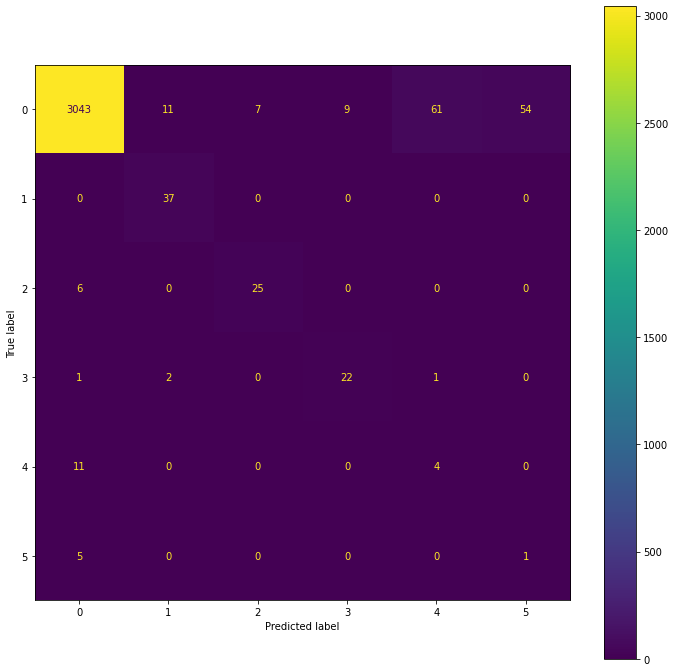

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3185
           1       0.74      1.00      0.85        37
           2       0.78      0.81      0.79        31
           3       0.71      0.85      0.77        26
           4       0.06      0.27      0.10        15
           5       0.02      0.17      0.03         6

    accuracy                           0.95      3300
   macro avg       0.55      0.67      0.59      3300
weighted avg       0.98      0.95      0.96      3300



In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
# Create the matrix
cm = confusion_matrix(y_test, y_pred_catb)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, y_pred_catb))

In [ ]:
print("Accuracy Score: %.4f" %(accuracy_score(y_test,y_pred_catb)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test,y_pred_catb)))

Accuracy Score: 0.9491
Matthews correlation coefficient: 0.5398


In [ ]:
catb_ov = CatBoostClassifier()
ovr = OneVsRestClassifier(catb_ov)

In [ ]:
ovr.fit(X1_res, y1_res)
yhat_ovr = ovr.predict(X_test)

In [ ]:
# Final pipeline combined with RandomForest
pipeline = Pipeline(
    steps=[("preprocess", full),("base",ovr)])

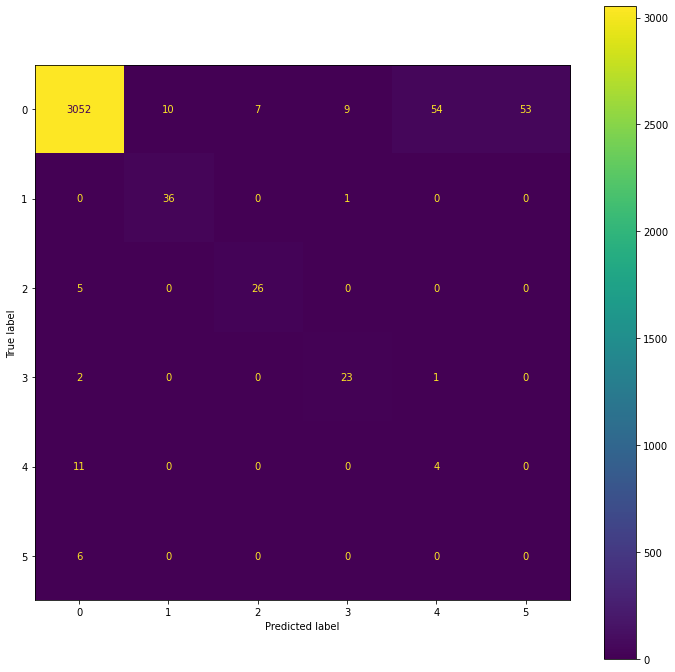

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3185
           1       0.78      0.97      0.87        37
           2       0.79      0.84      0.81        31
           3       0.70      0.88      0.78        26
           4       0.07      0.27      0.11        15
           5       0.00      0.00      0.00         6

    accuracy                           0.95      3300
   macro avg       0.55      0.65      0.59      3300
weighted avg       0.98      0.95      0.96      3300



In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
# Create the matrix
cm = confusion_matrix(y_test, yhat_ovr)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, yhat_ovr))

In [ ]:
print("Balanced Accuracy Score: %.4f" %(balanced_accuracy_score(y_test, yhat_ovr)))
print("Accuracy Score: %.4f" %(accuracy_score(y_test, yhat_ovr)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test, yhat_ovr)))

Balanced Accuracy Score: 0.6535
Accuracy Score: 0.9518
Matthews correlation coefficient: 0.5492


In [ ]:
catb_ovo = CatBoostClassifier()
ovo = OneVsOneClassifier(catb_ovo)

In [ ]:
ovo.fit(X1_res, y1_res)
yhat_ovo = ovo.predict(X_test)

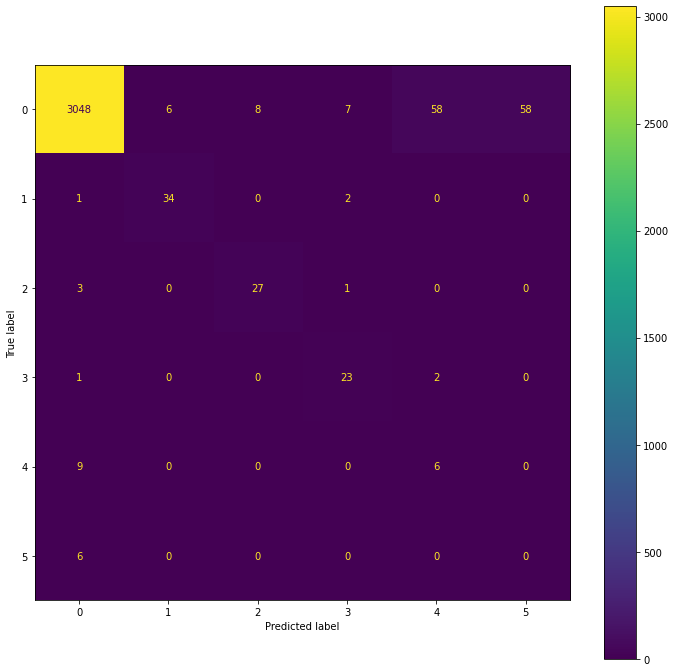

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3185
           1       0.85      0.92      0.88        37
           2       0.77      0.87      0.82        31
           3       0.70      0.88      0.78        26
           4       0.09      0.40      0.15        15
           5       0.00      0.00      0.00         6

    accuracy                           0.95      3300
   macro avg       0.57      0.67      0.60      3300
weighted avg       0.98      0.95      0.97      3300



In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
# Create the matrix
cm = confusion_matrix(y_test, yhat_ovo)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, yhat_ovo))

In [ ]:
print("Balanced Accuracy Score: %.4f" %(balanced_accuracy_score(y_test, yhat_ovo)))
print("Accuracy Score: %.4f" %(accuracy_score(y_test, yhat_ovo)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test, yhat_ovo)))

Balanced Accuracy Score: 0.6719
Accuracy Score: 0.9509
Matthews correlation coefficient: 0.5551


In [ ]:
rfc_ov = RandomForestClassifier()

In [ ]:
ovr = OneVsRestClassifier(rfc_ov)
ovr.fit(X1_res, y1_res)

OneVsRestClassifier(estimator=RandomForestClassifier())

In [ ]:
yhat_ovr = ovr.predict(X_test)

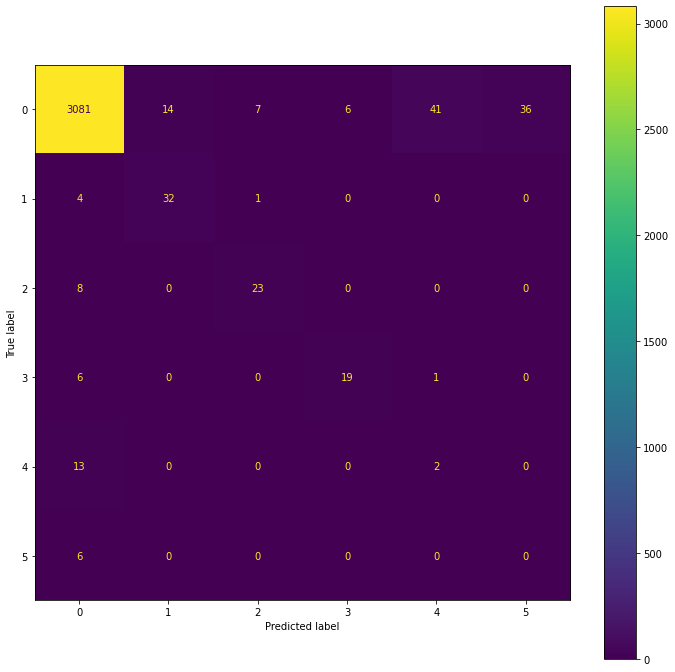

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3185
           1       0.70      0.86      0.77        37
           2       0.74      0.74      0.74        31
           3       0.76      0.73      0.75        26
           4       0.05      0.13      0.07        15
           5       0.00      0.00      0.00         6

    accuracy                           0.96      3300
   macro avg       0.54      0.57      0.55      3300
weighted avg       0.97      0.96      0.97      3300



In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
# Create the matrix
cm = confusion_matrix(y_test, yhat_ovr)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, yhat_ovr))

In [ ]:
print("Balanced Accuracy Score: %.4f" %(balanced_accuracy_score(y_test, yhat_ovr)))
print("Accuracy Score: %.4f" %(accuracy_score(y_test, yhat_ovr)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test, yhat_ovr)))

Balanced Accuracy Score: 0.5730
Accuracy Score: 0.9567
Matthews correlation coefficient: 0.5203


In [ ]:
ovo = OneVsOneClassifier(rfc_ov)

In [ ]:
ovo.fit(X1_res, y1_res)
yhat_ovo = ovo.predict(X_test)

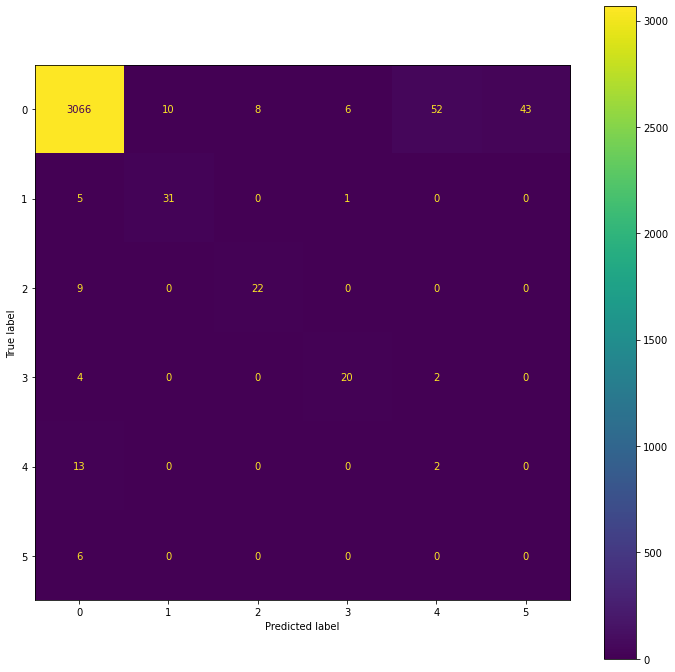

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3185
           1       0.76      0.84      0.79        37
           2       0.73      0.71      0.72        31
           3       0.74      0.77      0.75        26
           4       0.04      0.13      0.06        15
           5       0.00      0.00      0.00         6

    accuracy                           0.95      3300
   macro avg       0.54      0.57      0.55      3300
weighted avg       0.98      0.95      0.96      3300



In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
# Create the matrix
cm = confusion_matrix(y_test, yhat_ovo)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)
plt.show();
print(classification_report(y_test, yhat_ovo))

In [ ]:
print("Balanced Accuracy Score: %.4f" %(balanced_accuracy_score(y_test, yhat_ovo)))
print("Accuracy Score: %.4f" %(accuracy_score(y_test, yhat_ovo)))
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test, yhat_ovo)))

Balanced Accuracy Score: 0.5688
Accuracy Score: 0.9518
Matthews correlation coefficient: 0.4955
